# Introduction

The following code snippet was written to achieve the highest score in the Tabular playground series-March 2021 competition. The data given consists of **300000 rows** and **32 columns**. 32 columns are divided into **19 categorical (cat)**, **11 continuous (cont)**, **1 id** and **1 target**. Our aim is to obtain a high accuracy score by estimating target data from given categorical and continuous data.

**First of all**, we analyze the data provided with the pandas library. As a result of our analysis, we shape the data. In order to read the corrected data better, we visualize it with seaborn and matplotlib. Later, we divide the data into x (**independent variables**) and y (**dependent variable**). In order to train the model we have created, we need to convert categorical data into numerical data. For this, we use Label Encoder and in order to normalize data, we use Standard Scaler. Finally, we train the data with the parameters we have determined.

I hope it will be a useful resource for you. Let's begin...


# Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas_profiling import ProfileReport
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2021/train.csv
/kaggle/input/tabular-playground-series-mar-2021/test.csv


# Read the data

In [2]:
train_data = pd.read_csv("../input/tabular-playground-series-mar-2021/train.csv")
test_data = pd.read_csv("../input/tabular-playground-series-mar-2021/test.csv")

In [3]:
train_data

id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont2  \
0            0    A    I    A    B    B   BI    A    S    Q  ...  0.759439   
1            1    A    I    A    A    E   BI    K    W   AD  ...  0.386385   
2            2    A    K    A    A    E   BI    A    E   BM  ...  0.343255   
3            3    A    K    A    C    E   BI    A    Y   AD  ...  0.831147   
4            4    A    I    G    B    E   BI    C    G    Q  ...  0.338818   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
299995  499993    A    N    F    A    E   BU    A   AS    K  ...  0.662428   
299996  499995    A    K    A    A    G   BI    A    K   AE  ...  0.821657   
299997  499996    A    G    M    A    H   BI    C    L    F  ...  0.407037   
299998  499997    B    H    A    D    B   BI    A   AA   AX  ...  0.808045   
299999  499999    A    F    C    A    E   BI    C   AV    S  ...  0.775451   

           cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0       0.795549  0.681917  0.621672  0.592184  0.791921  0.815254  0.965006   
1       0.541366  0.388982  0.357778  0.600044  0.408701  0.399353  0.927406   
2       0.616352  0.793687  0.552877  0.352113  0.388835  0.412303  0.292696   
3       0.807807  0.800032  0.619147  0.221789  0.897617  0.633669  0.760318   
4       0.277308  0.610578  0.128291  0.578764  0.279167  0.351103  0.357084   
...          ...       ...       ...       ...       ...       ...       ...   
299995  0.671927  0.390566  0.145840  0.262767  0.514248  0.519340  0.617436   
299996  0.620356  0.384891  0.735879  0.547731  0.726653  0.470575  0.275743   
299997  0.232436  0.832482  0.810663  0.596939  0.308821  0.373997  0.518024   
299998  0.630708  0.346898  0.735147  0.563488  0.609836  0.680430  0.318453   
299999  0.848696  0.819377  0.355467  0.218153  0.968856  0.823655  0.330515   

          cont10 target  
0       0.665915      0  
1       0.493729      0  
2       0.549452      0  
3       0.934242      0  
4       0.328960      1  
...          ...    ...  
299995  0.688007      0  
299996  0.638939      0  
299997  0.452144      1  
299998  0.335822      0  
299999  0.972569      0  

[300000 rows x 32 columns]

In [4]:
test_data

id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont1  \
0            5    A    F    A    A    F   BI    A   AH   AX  ...  0.735690   
1            6    A    H    C    A    E   AB    I    F    N  ...  0.313703   
2            8    A    N    C    A    F   AB    A   AH   BC  ...  0.448201   
3            9    B    L    C    A    F   BI    A    E   AX  ...  0.666092   
4           11    A    F    A    B    F   BI    A   AH    I  ...  0.772229   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
199995  499983    A    N    A    D    F   BI    A   AF   AX  ...  0.361426   
199996  499984    B    I    A    B    E   BI    A   AS    S  ...  0.551106   
199997  499987    A    L    D    A    H   BI    A   AN    J  ...  0.812384   
199998  499994    A    K    A    C    F   BI    A    R   BM  ...  0.811282   
199999  499998    A    K    A    A    E   BI    C   AO   BM  ...  0.336168   

           cont2     cont3     cont4     cont5     cont6     cont7     cont8  \
0       0.578366  0.723154  0.228037  0.356227  0.551249  0.655693  0.598331   
1       0.928885  0.516602  0.600169  0.795224  0.248987  0.654614  0.347944   
2       0.424876  0.344729  0.242073  0.270632  0.746740  0.335590  0.341238   
3       0.598943  0.561971  0.806347  0.735983  0.538724  0.381566  0.481660   
4       0.479572  0.767745  0.252454  0.354810  0.178920  0.763479  0.562491   
...          ...       ...       ...       ...       ...       ...       ...   
199995  0.351946  0.327670  0.205547  0.679195  0.485967  0.319130  0.520681   
199996  0.628843  0.677765  0.624935  0.555306  0.242424  0.700829  0.531728   
199997  0.803348  0.324762  0.665624  0.488447  0.853213  0.578641  0.811941   
199998  0.820635  0.561449  0.797434  0.555089  0.746532  0.369986  0.438712   
199999  0.270483  0.581868  0.218993  0.553284  0.565213  0.378355  0.547927   

           cont9    cont10  
0       0.359987  0.947489  
1       0.565520  0.388580  
2       0.252289  0.411592  
3       0.348514  0.325723  
4       0.466261  0.585781  
...          ...       ...  
199995  0.519545  0.427119  
199996  0.528427  0.922645  
199997  0.537106  0.531758  
199998  0.715524  0.381978  
199999  0.273595  0.448016  

[200000 rows x 31 columns]

In [5]:
train_data=train_data.drop("id",axis=1)
test_data= test_data.drop("id",axis=1)

# Analyse the data

In [6]:
train_data.describe()

cont0          cont1          cont2          cont3  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.504749       0.494073       0.516632       0.474235   
std         0.206788       0.213037       0.214851       0.216636   
min        -0.049562       0.084480       0.094493      -0.045316   
25%         0.344985       0.317363       0.326047       0.292249   
50%         0.479650       0.463170       0.471247       0.387564   
75%         0.637657       0.693992       0.704625       0.644950   
max         1.004559       1.009958       1.016600       0.952187   

               cont4          cont5          cont6          cont7  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.504848       0.502257       0.488229       0.501739   
std         0.227474       0.241243       0.211335       0.203496   
min         0.168071      -0.036379       0.005199       0.090901   
25%         0.279303       0.276442       0.323914       0.353054   
50%         0.479858       0.554768       0.518089       0.435404   
75%         0.725779       0.735225       0.608537       0.642023   
max         0.858578       0.853022       0.966553       1.035818   

               cont8          cont9         cont10         target  
count  300000.000000  300000.000000  300000.000000  300000.000000  
mean        0.488074       0.469496       0.508230       0.264870  
std         0.179048       0.194516       0.203393       0.441265  
min         0.024139       0.214866       0.097789       0.000000  
25%         0.358915       0.309934       0.368312       0.000000  
50%         0.410908       0.407477       0.446576       0.000000  
75%         0.612725       0.586793       0.581957       1.000000  
max         1.055885       1.005652       1.011331       1.000000

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cat10   300000 non-null  object 
 11  cat11   300000 non-null  object 
 12  cat12   300000 non-null  object 
 13  cat13   300000 non-null  object 
 14  cat14   300000 non-null  object 
 15  cat15   300000 non-null  object 
 16  cat16   300000 non-null  object 
 17  cat17   300000 non-null  object 
 18  cat18   300000 non-null  object 
 19  cont0   300000 non-null  float64
 20  cont1   300000 non-null  float64
 21  cont2   30

In [8]:
test_data.describe()

cont0          cont1          cont2          cont3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.505388       0.493960       0.516425       0.475286   
std         0.207417       0.212695       0.214752       0.216919   
min        -0.044929       0.090478       0.098591      -0.038178   
25%         0.344748       0.317788       0.326210       0.292777   
50%         0.479633       0.463195       0.470893       0.392118   
75%         0.638773       0.693882       0.704745       0.645803   
max         1.006825       1.011597       1.012128       0.965609   

               cont4          cont5          cont6          cont7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.504772       0.501180       0.487315       0.502684   
std         0.227199       0.241375       0.211335       0.203793   
min         0.171321      -0.036337      -0.005648       0.096067   
25%         0.279413       0.275422       0.322365       0.353388   
50%         0.480299       0.554723       0.517318       0.436139   
75%         0.725272       0.735137       0.607454       0.646104   
max         0.867198       0.848617       0.964635       1.033760   

               cont8          cont9         cont10  
count  200000.000000  200000.000000  200000.000000  
mean        0.488331       0.469813       0.508974  
std         0.178895       0.194999       0.203926  
min         0.013554       0.215540       0.113059  
25%         0.359121       0.309888       0.368999  
50%         0.411318       0.407066       0.446578  
75%         0.612508       0.588008       0.583082  
max         1.053155       1.007189       1.007168

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    200000 non-null  object 
 1   cat1    200000 non-null  object 
 2   cat2    200000 non-null  object 
 3   cat3    200000 non-null  object 
 4   cat4    200000 non-null  object 
 5   cat5    200000 non-null  object 
 6   cat6    200000 non-null  object 
 7   cat7    200000 non-null  object 
 8   cat8    200000 non-null  object 
 9   cat9    200000 non-null  object 
 10  cat10   200000 non-null  object 
 11  cat11   200000 non-null  object 
 12  cat12   200000 non-null  object 
 13  cat13   200000 non-null  object 
 14  cat14   200000 non-null  object 
 15  cat15   200000 non-null  object 
 16  cat16   200000 non-null  object 
 17  cat17   200000 non-null  object 
 18  cat18   200000 non-null  object 
 19  cont0   200000 non-null  float64
 20  cont1   200000 non-null  float64
 21  cont2   20

In [10]:
zero_target_count = train_data[train_data["target"] == 0].count()[0]
print(zero_target_count)

220539


In [11]:
one_target_count = train_data[train_data["target"] == 1].count()[0]
print(one_target_count)

79461


In [12]:
different_values = [c for c in train_data["target"] if c != 0 and c != 1]
print(different_values)

[]


### As you see, The target just consist of 0s and 1s and has too many 0s if we look 1s. So we should balance it to better training. There are so many technics to balance it but I chose to delete the rows we wanted by sorting the data because this is faster technic. First, we sort the data by target and We delete some rows with targets 0.

In [13]:
zo_differance = zero_target_count - one_target_count
print(zo_differance)

141078


In [14]:
train = train_data.sort_values(by="target", ascending=True)
train = train.reset_index(drop=True)
train

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont2  \
0         A    I    A    B    B   BI    A    S    Q    A  ...  0.759439   
1         B    I    A    B    E   BI    C    U   AS    I  ...  0.291842   
2         B    I    F    B    E   BI    C    E   AX    F  ...  0.282734   
3         B    F    G    A    F   BI    C   AG   AE    A  ...  0.292041   
4         A    I    A    A    G   BI    C   AN    H    E  ...  0.471337   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
299995    A    M    C    A    F   BI    C   AH   BN    E  ...  0.194454   
299996    A    O    O    A    H   BI    A    E   AG    A  ...  0.720718   
299997    A    I    A    B    E   BI    A   AX   AX    A  ...  0.414301   
299998    A    K    A    C    E   BI    A   AH   BM    I  ...  0.304059   
299999    A    I    A    B    E   BI    C   AH   AE    A  ...  0.299077   

           cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0       0.795549  0.681917  0.621672  0.592184  0.791921  0.815254  0.965006   
1       0.589717  0.347862  0.735642  0.567588  0.388346  0.392792  0.547941   
2       0.619783  0.211527  0.740120  0.517751  0.344051  0.397866  0.545955   
3       0.575118  0.699979  0.807113  0.735064  0.263166  0.161043  0.259758   
4       0.211008  0.777254  0.739184  0.607176  0.447446  0.401302  0.291068   
...          ...       ...       ...       ...       ...       ...       ...   
299995  0.586735  0.226972  0.781371  0.597072  0.334407  0.454079  0.362669   
299996  0.274150  0.804704  0.774529  0.723619  0.401671  0.970290  0.530038   
299997  0.580341  0.232338  0.679402  0.475724  0.362586  0.384953  0.587518   
299998  0.600025  0.256751  0.734928  0.541749  0.379252  0.370546  0.457191   
299999  0.609204  0.240598  0.554222  0.393367  0.389764  0.348209  0.236791   

          cont10  target  
0       0.665915       0  
1       0.374847       0  
2       0.440943       0  
3       0.373598       0  
4       0.385259       0  
...          ...     ...  
299995  0.329772       1  
299996  0.441067       1  
299997  0.433132       1  
299998  0.314010       1  
299999  0.328152       1  

[300000 rows x 31 columns]

In [15]:
train = train.drop(train.index[range(zo_differance)])
train = train.reset_index(drop=True)
train

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont2  \
0         A    H    C    B    F   BI    I    U   AD    A  ...  0.658067   
1         B    A    A    A    E   BI    A    J    L    A  ...  0.351403   
2         A    G    A    A    F   BI    A    K    L    A  ...  0.766482   
3         A    I    A    A    F   BI    A   AF    H    E  ...  0.944501   
4         B    I    A    B    F   BI    G    E   BM    A  ...  0.225137   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
158917    A    M    C    A    F   BI    C   AH   BN    E  ...  0.194454   
158918    A    O    O    A    H   BI    A    E   AG    A  ...  0.720718   
158919    A    I    A    B    E   BI    A   AX   AX    A  ...  0.414301   
158920    A    K    A    C    E   BI    A   AH   BM    I  ...  0.304059   
158921    A    I    A    B    E   BI    C   AH   AE    A  ...  0.299077   

           cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0       0.661320  0.198827  0.267590  0.444564  0.685665  0.506683  0.267436   
1       0.584441  0.733793  0.620545  0.205549  0.399058  0.357201  0.314263   
2       0.861469  0.283656  0.553155  0.232433  0.851830  0.690979  0.834592   
3       0.324844  0.196726  0.810045  0.571702  0.428676  0.915440  0.577359   
4       0.559352  0.782949  0.818455  0.628551  0.391640  0.234246  0.727194   
...          ...       ...       ...       ...       ...       ...       ...   
158917  0.586735  0.226972  0.781371  0.597072  0.334407  0.454079  0.362669   
158918  0.274150  0.804704  0.774529  0.723619  0.401671  0.970290  0.530038   
158919  0.580341  0.232338  0.679402  0.475724  0.362586  0.384953  0.587518   
158920  0.600025  0.256751  0.734928  0.541749  0.379252  0.370546  0.457191   
158921  0.609204  0.240598  0.554222  0.393367  0.389764  0.348209  0.236791   

          cont10  target  
0       0.820721       0  
1       0.322878       0  
2       0.978653       0  
3       0.534960       0  
4       0.345541       0  
...          ...     ...  
158917  0.329772       1  
158918  0.441067       1  
158919  0.433132       1  
158920  0.314010       1  
158921  0.328152       1  

[158922 rows x 31 columns]

In [16]:
z,o=train[train["target"]==0].count()[0],train[train["target"]==1].count()[0]
print("target has: {} zero and {} one".format(z,o))

target has: 79461 zero and 79461 one


### Now we have an equal number of 0s and 1s.

# Visualizing the data

## Historam graphs for continuous columns

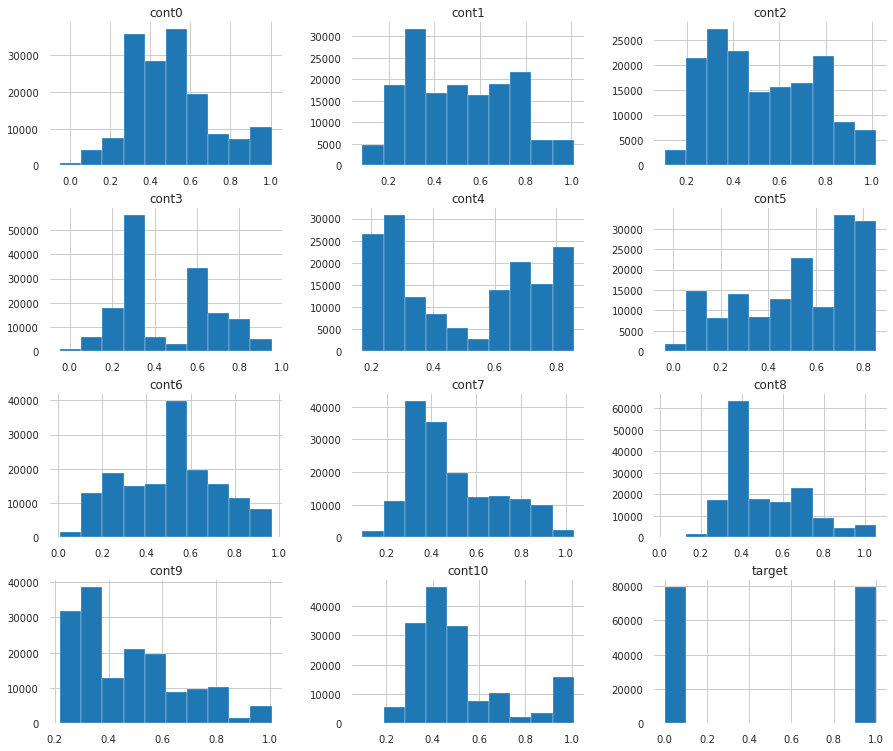

In [17]:
train.hist(figsize=(15,30),layout=(9,3))
plt.show()

## Density analyse for continuous rows

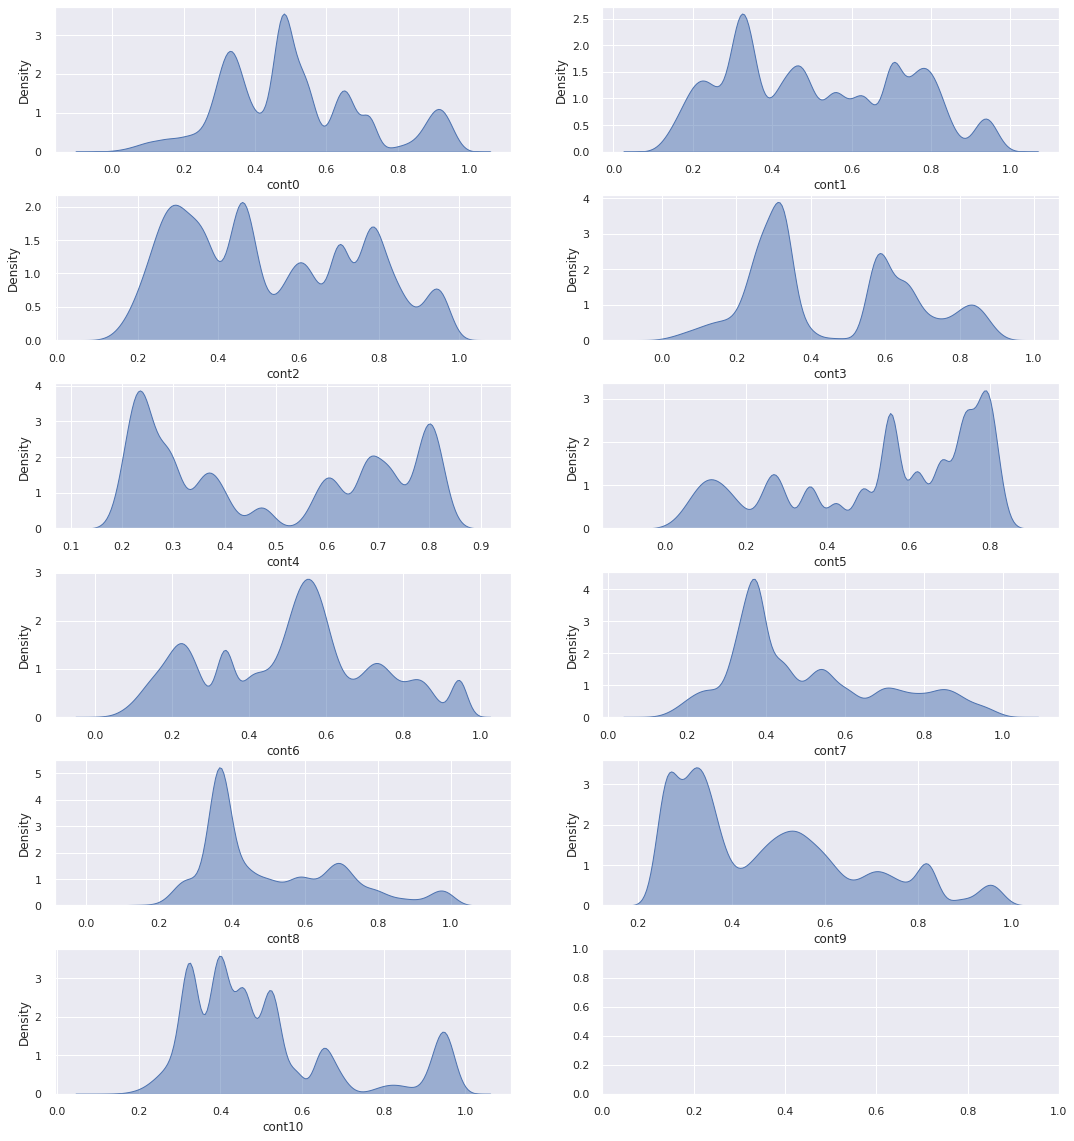

In [18]:
sns.set_theme()
fig,axes= plt.subplots(6,2, figsize=(18,20))
k=0
for i in range(6):
    for j in range(2):
        sns.kdeplot(
            ax=axes[i,j],x="cont{}".format(k),
            data=train, fill=True, common_norm=False,
            palette="crest",alpha=.5, linewidth=1)
        k+=1
        if k==11:
            break

fig.subplots_adjust(hspace=0.3)
plt.show()

## Profile report for the data

In [19]:
x_profile = ProfileReport(train, title='Profiling Report Of Data', html={'style':{'full_width':True}})

In [20]:
x_profile

Summarize dataset:   0%|          | 0/45 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Split data into independent values and dependent value

In [21]:
xtrain= train.drop("target",axis=1)
ytrain= train["target"]

In [22]:
xtrain

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont1  \
0         A    H    C    B    F   BI    I    U   AD    A  ...  0.479713   
1         B    A    A    A    E   BI    A    J    L    A  ...  0.349277   
2         A    G    A    A    F   BI    A    K    L    A  ...  0.760604   
3         A    I    A    A    F   BI    A   AF    H    E  ...  0.921603   
4         B    I    A    B    F   BI    G    E   BM    A  ...  0.351395   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
158917    A    M    C    A    F   BI    C   AH   BN    E  ...  0.338346   
158918    A    O    O    A    H   BI    A    E   AG    A  ...  0.819444   
158919    A    I    A    B    E   BI    A   AX   AX    A  ...  0.388957   
158920    A    K    A    C    E   BI    A   AH   BM    I  ...  0.293037   
158921    A    I    A    B    E   BI    C   AH   AE    A  ...  0.239205   

           cont2     cont3     cont4     cont5     cont6     cont7     cont8  \
0       0.658067  0.661320  0.198827  0.267590  0.444564  0.685665  0.506683   
1       0.351403  0.584441  0.733793  0.620545  0.205549  0.399058  0.357201   
2       0.766482  0.861469  0.283656  0.553155  0.232433  0.851830  0.690979   
3       0.944501  0.324844  0.196726  0.810045  0.571702  0.428676  0.915440   
4       0.225137  0.559352  0.782949  0.818455  0.628551  0.391640  0.234246   
...          ...       ...       ...       ...       ...       ...       ...   
158917  0.194454  0.586735  0.226972  0.781371  0.597072  0.334407  0.454079   
158918  0.720718  0.274150  0.804704  0.774529  0.723619  0.401671  0.970290   
158919  0.414301  0.580341  0.232338  0.679402  0.475724  0.362586  0.384953   
158920  0.304059  0.600025  0.256751  0.734928  0.541749  0.379252  0.370546   
158921  0.299077  0.609204  0.240598  0.554222  0.393367  0.389764  0.348209   

           cont9    cont10  
0       0.267436  0.820721  
1       0.314263  0.322878  
2       0.834592  0.978653  
3       0.577359  0.534960  
4       0.727194  0.345541  
...          ...       ...  
158917  0.362669  0.329772  
158918  0.530038  0.441067  
158919  0.587518  0.433132  
158920  0.457191  0.314010  
158921  0.236791  0.328152  

[158922 rows x 30 columns]

In [23]:
ytrain

0         0
1         0
2         0
3         0
4         0
         ..
158917    1
158918    1
158919    1
158920    1
158921    1
Name: target, Length: 158922, dtype: int64

# Converting categorical datas

In [24]:
l_encoder= LabelEncoder()

In [25]:
cats=[cat for cat in xtrain.columns if "cat" in cat]
conts=[cont for cont in xtrain.columns if "cont" in cont]

In [26]:
cats

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18']

In [27]:
conts

['cont0',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10']

In [28]:
xtrain

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont1  \
0         A    H    C    B    F   BI    I    U   AD    A  ...  0.479713   
1         B    A    A    A    E   BI    A    J    L    A  ...  0.349277   
2         A    G    A    A    F   BI    A    K    L    A  ...  0.760604   
3         A    I    A    A    F   BI    A   AF    H    E  ...  0.921603   
4         B    I    A    B    F   BI    G    E   BM    A  ...  0.351395   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
158917    A    M    C    A    F   BI    C   AH   BN    E  ...  0.338346   
158918    A    O    O    A    H   BI    A    E   AG    A  ...  0.819444   
158919    A    I    A    B    E   BI    A   AX   AX    A  ...  0.388957   
158920    A    K    A    C    E   BI    A   AH   BM    I  ...  0.293037   
158921    A    I    A    B    E   BI    C   AH   AE    A  ...  0.239205   

           cont2     cont3     cont4     cont5     cont6     cont7     cont8  \
0       0.658067  0.661320  0.198827  0.267590  0.444564  0.685665  0.506683   
1       0.351403  0.584441  0.733793  0.620545  0.205549  0.399058  0.357201   
2       0.766482  0.861469  0.283656  0.553155  0.232433  0.851830  0.690979   
3       0.944501  0.324844  0.196726  0.810045  0.571702  0.428676  0.915440   
4       0.225137  0.559352  0.782949  0.818455  0.628551  0.391640  0.234246   
...          ...       ...       ...       ...       ...       ...       ...   
158917  0.194454  0.586735  0.226972  0.781371  0.597072  0.334407  0.454079   
158918  0.720718  0.274150  0.804704  0.774529  0.723619  0.401671  0.970290   
158919  0.414301  0.580341  0.232338  0.679402  0.475724  0.362586  0.384953   
158920  0.304059  0.600025  0.256751  0.734928  0.541749  0.379252  0.370546   
158921  0.299077  0.609204  0.240598  0.554222  0.393367  0.389764  0.348209   

           cont9    cont10  
0       0.267436  0.820721  
1       0.314263  0.322878  
2       0.834592  0.978653  
3       0.577359  0.534960  
4       0.727194  0.345541  
...          ...       ...  
158917  0.362669  0.329772  
158918  0.530038  0.441067  
158919  0.587518  0.433132  
158920  0.457191  0.314010  
158921  0.236791  0.328152  

[158922 rows x 30 columns]

In [29]:
for i in cats:
    xtrain[i]= l_encoder.fit_transform(xtrain[i])
    test_data[i]= l_encoder.fit_transform(test_data[i])
    

In [30]:
xtrain

cat0  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  ...  \
0          0     7     2     1     5    33     7    46     3     0  ...   
1          1     0     0     0     4    33     0    35    49     0  ...   
2          0     6     0     0     5    33     0    36    49     0  ...   
3          0     8     0     0     5    33     0     6    45     4  ...   
4          1     8     0     1     5    33     6    30    38     0  ...   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
158917     0    12     2     0     5    33     2     8    39     4  ...   
158918     0    14    14     0     7    33     0    30     6     0  ...   
158919     0     8     0     1     4    33     0    24    23     0  ...   
158920     0    10     0     2     4    33     0     8    38     7  ...   
158921     0     8     0     1     4    33     2     8     4     0  ...   

           cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0       0.479713  0.658067  0.661320  0.198827  0.267590  0.444564  0.685665   
1       0.349277  0.351403  0.584441  0.733793  0.620545  0.205549  0.399058   
2       0.760604  0.766482  0.861469  0.283656  0.553155  0.232433  0.851830   
3       0.921603  0.944501  0.324844  0.196726  0.810045  0.571702  0.428676   
4       0.351395  0.225137  0.559352  0.782949  0.818455  0.628551  0.391640   
...          ...       ...       ...       ...       ...       ...       ...   
158917  0.338346  0.194454  0.586735  0.226972  0.781371  0.597072  0.334407   
158918  0.819444  0.720718  0.274150  0.804704  0.774529  0.723619  0.401671   
158919  0.388957  0.414301  0.580341  0.232338  0.679402  0.475724  0.362586   
158920  0.293037  0.304059  0.600025  0.256751  0.734928  0.541749  0.379252   
158921  0.239205  0.299077  0.609204  0.240598  0.554222  0.393367  0.389764   

           cont8     cont9    cont10  
0       0.506683  0.267436  0.820721  
1       0.357201  0.314263  0.322878  
2       0.690979  0.834592  0.978653  
3       0.915440  0.577359  0.534960  
4       0.234246  0.727194  0.345541  
...          ...       ...       ...  
158917  0.454079  0.362669  0.329772  
158918  0.970290  0.530038  0.441067  
158919  0.384953  0.587518  0.433132  
158920  0.370546  0.457191  0.314010  
158921  0.348209  0.236791  0.328152  

[158922 rows x 30 columns]

In [31]:
test_data

cat0  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  ...  \
0          0     5     0     0     5    33     0     8    23     0  ...   
1          0     7     2     0     4     2     7    31    51     0  ...   
2          0    13     2     0     5     2     0     8    28     0  ...   
3          1    11     2     0     5    33     0    30    23     0  ...   
4          0     5     0     1     5    33     0     8    46     0  ...   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
199995     0    13     0     3     5    33     0     6    23     0  ...   
199996     1     8     0     1     4    33     0    19    55     4  ...   
199997     0    11     3     0     7    33     0    14    47     0  ...   
199998     0    10     0     2     5    33     0    43    38     0  ...   
199999     0    10     0     0     4    33     2    15    38     7  ...   

           cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0       0.735690  0.578366  0.723154  0.228037  0.356227  0.551249  0.655693   
1       0.313703  0.928885  0.516602  0.600169  0.795224  0.248987  0.654614   
2       0.448201  0.424876  0.344729  0.242073  0.270632  0.746740  0.335590   
3       0.666092  0.598943  0.561971  0.806347  0.735983  0.538724  0.381566   
4       0.772229  0.479572  0.767745  0.252454  0.354810  0.178920  0.763479   
...          ...       ...       ...       ...       ...       ...       ...   
199995  0.361426  0.351946  0.327670  0.205547  0.679195  0.485967  0.319130   
199996  0.551106  0.628843  0.677765  0.624935  0.555306  0.242424  0.700829   
199997  0.812384  0.803348  0.324762  0.665624  0.488447  0.853213  0.578641   
199998  0.811282  0.820635  0.561449  0.797434  0.555089  0.746532  0.369986   
199999  0.336168  0.270483  0.581868  0.218993  0.553284  0.565213  0.378355   

           cont8     cont9    cont10  
0       0.598331  0.359987  0.947489  
1       0.347944  0.565520  0.388580  
2       0.341238  0.252289  0.411592  
3       0.481660  0.348514  0.325723  
4       0.562491  0.466261  0.585781  
...          ...       ...       ...  
199995  0.520681  0.519545  0.427119  
199996  0.531728  0.528427  0.922645  
199997  0.811941  0.537106  0.531758  
199998  0.438712  0.715524  0.381978  
199999  0.547927  0.273595  0.448016  

[200000 rows x 30 columns]

In [32]:
pipline=Pipeline([
    ("scale",StandardScaler())
])

In [33]:
ct=ColumnTransformer(
    [("scale",pipline,cats)],
    remainder="passthrough")

In [34]:
xtrain= ct.fit_transform(xtrain)
test_data=ct.fit_transform(test_data)

In [35]:
ytrain= ytrain.values.ravel()

# Last analysing before training

In [36]:
ols_model= sm.OLS(ytrain,xtrain).fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.702
Model:                            OLS   Adj. R-squared (uncentered):              0.702
Method:                 Least Squares   F-statistic:                          1.248e+04
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                        0.00
Time:                        14:33:39   Log-Likelihood:                         -74194.
No. Observations:              158922   AIC:                                  1.484e+05
Df Residuals:                  158892   BIC:                                  1.487e+05
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### This is a very useful analysis method. In the table, you can see the R-squared and P-value(P>|t|) values, which are very useful for data analysis. The closer to R-squared 1 is, the more likely we are to have a successful training. For p-value, there are separately calculated values for all columns. Usually p-value less than 0.05 indicates that we have a good training set but I do not want to consider p-value for now because our R-squared value looks pretty good. If we are not satisfied with the accuracy score, we can delete the columns with p-value higher than 0.05 or change the encoder.

# Model

In [37]:
def kfold(x,y,model,folds=4):
    roc_score=[]
    skf= StratifiedKFold(n_splits= folds, shuffle= True, random_state=38)
    
    for fold,(train_index,test_index) in enumerate(skf.split(x,y)):
        print("Fold: {}".format(fold))
        xtrain, xtest, ytrain, ytest = x[train_index], x[test_index], y[train_index], y[test_index]
        model.fit(xtrain,ytrain,eval_set=[(xtest,ytest)], eval_metric = ["auc","error"], verbose= False)
        ypred= model.predict_proba(xtest)[:,1]
        score= roc_auc_score(ytest,ypred)
        roc_score.append(score)
        print("roc_auc_score: {}".format(score))
        print("*"*50)
    
    roc_score_mean= np.mean(roc_score)   
    return model, roc_score_mean 

In [38]:
lgbm= LGBMClassifier()

# Train with StratifiedKFold

In [39]:
model,score=kfold(xtrain,ytrain,model=lgbm)

Fold: 0
roc_auc_score: 0.8893436958910885
**************************************************
Fold: 1
roc_auc_score: 0.8878560252508824
**************************************************
Fold: 2
roc_auc_score: 0.8883232331704903
**************************************************
Fold: 3
roc_auc_score: 0.8869324167681307
**************************************************


In [40]:
score

0.888113842770148

# Calibration of our model

### When the probability prediction of a data point belonging to a class is very important, we calibrate our model.

In [41]:
calibrated_model= CalibratedClassifierCV(base_estimator= lgbm, cv=4,method='isotonic')

In [42]:
calibrated_model.fit(xtrain,ytrain)

CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv=4, method='isotonic')

In [43]:
roc_auc_score(ytrain, calibrated_model.predict_proba(xtrain)[:, 1])

0.8965326094038708

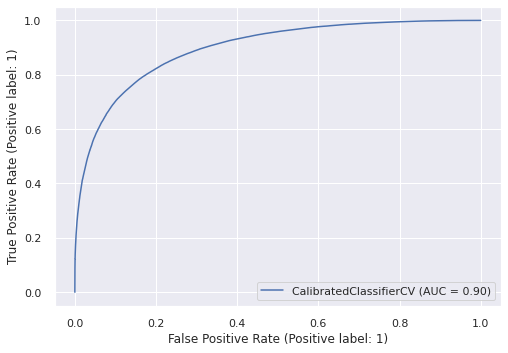

In [44]:
plot_roc_curve(calibrated_model, xtrain, ytrain)

In [45]:
test_data

array([[-0.58487154, -1.01120305, -0.63623041, ...,  0.59833054,
         0.35998748,  0.94748914],
       [-0.58487154, -0.36206283, -0.15275887, ...,  0.34794357,
         0.56551997,  0.38858002],
       [-0.58487154,  1.58535784, -0.15275887, ...,  0.34123794,
         0.25228895,  0.41159233],
       ...,
       [-0.58487154,  0.93621762,  0.08897689, ...,  0.81194084,
         0.53710645,  0.53175786],
       [-0.58487154,  0.61164751, -0.63623041, ...,  0.43871185,
         0.71552414,  0.38197823],
       [-0.58487154,  0.61164751, -0.63623041, ...,  0.54792701,
         0.27359458,  0.4480158 ]])

# Submission

In [46]:
submission = pd.read_csv("../input/tabular-playground-series-mar-2021/sample_submission.csv")

In [47]:
submission

id  target
0            5     0.5
1            6     0.5
2            8     0.5
3            9     0.5
4           11     0.5
...        ...     ...
199995  499983     0.5
199996  499984     0.5
199997  499987     0.5
199998  499994     0.5
199999  499998     0.5

[200000 rows x 2 columns]

In [48]:
submission["target"] = calibrated_model.predict_proba(test_data)[:, 1]
submission.to_csv("lgbm_combokonn.csv", index=False)